# Filtering and summarizing expert rankings

Now that all of the expert ranking data is downloaded and saved, I use pandas to calculate mean/median rankings and then rank by position. Finally, it's all saved to a spreadsheet.

In [1]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import datetime

## Filtering experts and then trimming down the rankings pool

In [2]:
TODAYS_DATE = datetime.date.today().strftime("%Y_%m_%d")
SCORING_TYPE = 'ppr'

In [3]:
expert_list_file = 'data/fp_experts_{}_{}.tsv'.format(SCORING_TYPE, TODAYS_DATE)
expert_df = pd.read_csv(expert_list_file,sep='\t')
print(expert_df.head())

         date  draft_rank  expert_id  in_season_rank             name  \
0  2017-08-23       108.0          3           104.0    Eric Karabell   
1  2017-08-23         NaN          5             NaN  Staff Composite   
2  2017-08-25        69.0          7            65.0     Andy Behrens   
3  2017-08-25        28.0          9            66.0  Scott Pianowski   
4  2017-08-23        76.0         15             8.0   Staff Rankings   

          source  
0           ESPN  
1           ESPN  
2  Yahoo! Sports  
3  Yahoo! Sports  
4   ScoutFantasy  


First we'll compute how "old" each ranking is.

In [4]:
expert_df['date'] = pd.to_datetime(expert_df['date'])
expert_df['days_ago'] = (datetime.date.today() - expert_df['date']).dt.days
print(expert_df.head())

        date  draft_rank  expert_id  in_season_rank             name  \
0 2017-08-23       108.0          3           104.0    Eric Karabell   
1 2017-08-23         NaN          5             NaN  Staff Composite   
2 2017-08-25        69.0          7            65.0     Andy Behrens   
3 2017-08-25        28.0          9            66.0  Scott Pianowski   
4 2017-08-23        76.0         15             8.0   Staff Rankings   

          source  days_ago  
0           ESPN         2  
1           ESPN         2  
2  Yahoo! Sports         0  
3  Yahoo! Sports         0  
4   ScoutFantasy         2  


Then we'll filter on rankings age. We could also filter based on each expert's overall ranking from last year, etc., but I think the more data the better.

In [5]:
filtered_experts = expert_df[expert_df['days_ago'] < 8][['expert_id','days_ago']]
print(len(filtered_experts))

82


In [6]:
expert_rankings_file = 'data/fp_rankings_{}_{}.tsv'.format(SCORING_TYPE,TODAYS_DATE)
all_rankings = pd.read_csv(expert_rankings_file, sep='\t')
print(all_rankings.head())
print(len(all_rankings))

   expert_id        player_name position  rank team
0          3      David Johnson       RB     1  ARI
1          3       Le'Veon Bell       RB     2  PIT
2          3      Antonio Brown       WR     3  PIT
3          3  Odell Beckham Jr.       WR     4  NYG
4          3         Mike Evans       WR     5   TB
21793


Now that we have all of the rankings read in, we'll filter out the old experts.

In [7]:
filtered_expert_ids = filtered_experts['expert_id'].tolist()
filtered_rankings = all_rankings[all_rankings['expert_id'].isin(filtered_expert_ids)]
print(len(filtered_rankings))

20358


Next we'll filter again based on how many rankings each player has across all the expert lists.

In [8]:
ranking_counts = filtered_rankings.groupby(['player_name','team','position']).size()
print(ranking_counts.head())
print(len(ranking_counts))

player_name      team  position
A.J. Derby       DEN   TE          14
A.J. Green       CIN   WR          82
Aaron Jones      GB    RB          20
Aaron Ripkowski  GB    RB           1
Aaron Rodgers    GB    QB          82
dtype: int64
459


There are 459 different players that have at least 1 ranking. Let's make a KDE plot to see what a cut-off value is.

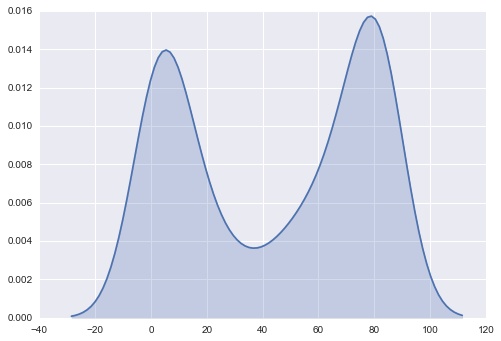

In [9]:
sns.kdeplot(ranking_counts, shade=True);

Based on this plot, it looks like appearing in 40 expert rankings is a reasonable cut-off.

In [10]:
RANKING_CUTOFF = 40
filtered_rankings = filtered_rankings.groupby(['player_name','team','position']).filter(lambda x: len(x) > RANKING_CUTOFF)
print(len(filtered_rankings))

18510


Ok, we have a pretty good dataset now, and we're only down to 18,510 observations (from 21,793 originally).

In [11]:
filtered_rankings_file = 'data/fp_rankings_{}_{}_filtered.tsv'.format(SCORING_TYPE,TODAYS_DATE)
filtered_rankings.to_csv(filtered_rankings_file, sep='\t', index=False)

## Computing summary statistics on rankings

In [12]:
overall_ranks = filtered_rankings.groupby(['player_name', 'position','team'],
                                     as_index=False).agg({'rank':[np.median, np.mean]})
overall_ranks.columns = ['player_name','position','team','median_rank','mean_rank']
overall_ranks.sort_values(['median_rank','mean_rank'], ascending=True, inplace=True)
print(overall_ranks.head())

           player_name position team  median_rank  mean_rank
64       David Johnson       RB  ARI          1.0   1.195122
158       Le'Veon Bell       RB  PIT          2.0   1.841463
14       Antonio Brown       WR  PIT          3.0   3.475610
141        Julio Jones       WR  ATL          5.0   5.682927
194  Odell Beckham Jr.       WR  NYG          5.0   5.756098


In [13]:
position_ranks = overall_ranks.groupby('position')['median_rank'].rank(method='first')
position_ranks = position_ranks.to_frame(name='position_rank')
position_ranks['position_rank'] = position_ranks['position_rank'].astype(int)
print(position_ranks.head())

     position_rank
64               1
158              2
14               1
141              2
194              3


In [14]:
overall_ranks = overall_ranks.join(position_ranks)
print(overall_ranks.head(10))

           player_name position team  median_rank  mean_rank  position_rank
64       David Johnson       RB  ARI          1.0   1.195122              1
158       Le'Veon Bell       RB  PIT          2.0   1.841463              2
14       Antonio Brown       WR  PIT          3.0   3.475610              1
141        Julio Jones       WR  ATL          5.0   5.682927              2
194  Odell Beckham Jr.       WR  NYG          5.0   5.756098              3
160       LeSean McCoy       RB  BUF          6.0   6.073171              3
179      Melvin Gordon       RB  LAC          8.0   8.341463              4
182         Mike Evans       WR   TB          9.0   9.182927              4
0           A.J. Green       WR  CIN          9.0   9.475610              5
78     Devonta Freeman       RB  ATL          9.0   9.926829              5


## Saving to a spreadsheet

First, we'll save it to a machine-readable TSV file before moving on to a human-readable spreadsheet.

In [15]:
overall_rankings_file = 'data/fp_rankings_{}_{}_summary.tsv'.format(SCORING_TYPE,TODAYS_DATE)
overall_ranks.to_csv(overall_rankings_file, sep='\t', index=False)

In [16]:
filename = 'rankings_summary_{}_{}.xlsx'.format(SCORING_TYPE,TODAYS_DATE)
writer = pd.ExcelWriter(filename, engine='xlsxwriter')

In [17]:
overall_ranks = overall_ranks[['player_name','position','position_rank','team','median_rank','mean_rank']]
overall_ranks.to_excel(writer,sheet_name='Overall', index=False)

In [18]:
for position in ['WR','RB','TE','QB','D/ST','K']:
    position_ranks = overall_ranks[overall_ranks['position'] == position]
    if position == 'D/ST': # Since player_name and team are redundant
        position_ranks = position_ranks[['player_name','median_rank','mean_rank']]
        # Excel doesn't allow slashes in sheetnames
        position_ranks.to_excel(writer, sheet_name='DEF', index=False)
    else:
        position_ranks = position_ranks[['player_name','team','median_rank','mean_rank']]
        position_ranks.to_excel(writer, sheet_name=position, index=False)
writer.save()